# Forecasting COVID-19 Cases

In [2]:
import os
import sys
# appending main project directory to notebook path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# autocompletion for notebook
%config IPCompleter.greedy=True

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
import pandas as pd
import datetime
from config.main_config import DATA_PATH
from pathlib import Path

In [30]:
from pmdarima import auto_arima
import statsmodels as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

In [7]:
import matplotlib.pyplot as plt

In [98]:
import plotly.express as px
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output


# EDA

In [8]:
casesdf = pd.read_csv(Path(DATA_PATH,'CONVENIENT_global_confirmed_cases.csv'))


In [9]:
casesdf.head()

,Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom.10,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,Province/State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australian Capital Territory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
casesdf.iloc[:,0]

0      Province/State
1             1/23/20
2             1/24/20
3             1/25/20
4             1/26/20
            ...      
381            2/6/21
382            2/7/21
383            2/8/21
384            2/9/21
385           2/10/21
Name: Country/Region, Length: 386, dtype: object

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-195-cd61005652b6> in update_figure(country='Country/Region')
     38     testdata = tsdata.iloc[sersplit-1:]
     39 
---> 40     plotdf = make_prediction(traindata,testdata)
        plotdf = undefined
        global make_prediction = <function make_prediction at 0x0000027EF8B9CB70>
        traindata =            Country/Region
Date                     
2020-03-02         3/2/20
2020-03-03         3/3/20
2020-03-04         3/4/20
2020-03-05         3/5/20
2020-03-06         3/6/20
...                   ...
2020-11-29       11/29/20
2020-11-30       11/30/20
2020-12-01        12/1/20
2020-12-02        12/2/20
2020-12-03        12/3/20

[277 rows x 1 columns]
        testdata =            Country/Region
Date                     
2020-12-03        12/3/20
2020-12-04        12/4/20
2020-12-05        12/5/20
2020-12-06        

## Modelling

In [10]:
# skipping first row (header row) and resetting index to begin at 0
dates = pd.to_datetime(casesdf['Country/Region'][1:], format="%m/%d/%y")
tsdata = pd.DataFrame(casesdf['United Kingdom.10'][1:])
tsdata.index = dates
tsdata.index.freq='d' # setting time frequency to be by date
tsdata = tsdata.rename_axis('Date')
tsdata = tsdata[tsdata.index>'03-01-2020']

# splitting 80% into trainset and 20% into testset
sersplit = round(len(tsdata)*0.8)
traindata = tsdata.iloc[:sersplit]
testdata = tsdata.iloc[sersplit:]

In [51]:
# prediction horizon - how far to forecast
pred_horizon=len(testdata)

In [75]:
model = auto_arima(traindata, seasonal=True, trace=True, trend='t')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=4866.572, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4907.696, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4883.177, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4875.713, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4907.696, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=4869.629, Time=0.54 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=4867.849, Time=0.67 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=4869.205, Time=1.08 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=4868.476, Time=1.60 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=4872.424, Time=0.28 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=4867.621, Time=0.87 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=4867.225, Time=0.93 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=4870.469, Time=1.81 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=4866.355, Time=0.49 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept

In [76]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  277
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -2425.789
Date:                           Fri, 12 Feb 2021   AIC                           4863.578
Time:                                   13:56:39   BIC                           4885.300
Sample:                                        0   HQIC                          4872.295
                                           - 277                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0367      0.099      0.370      0.711      -0.158       0.231
ar.L1          0.3073      0.104      2.961      0.003       0.104       0.511
ma.L1         -0.6853      0.084     -8.169      0.000      -0.850      -0.521
ar.S.L7        0.6935      0.129      5.390      0.000       0.441       0.946
ma.S.L7       -0.4774      0.140     -3.416      0.001      -0.751      -0.203
sigma2      2.514e+06      8e+04     31.446      0.000    2.36e+06    2.67e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6270.20
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              38.66   Skew:                             2.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

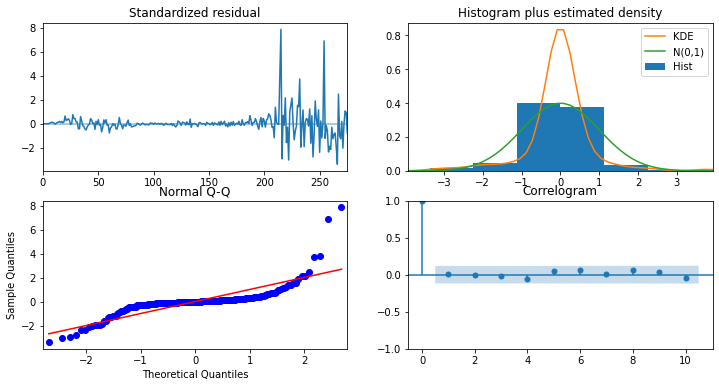

In [77]:
model.plot_diagnostics(figsize=(12,6));

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

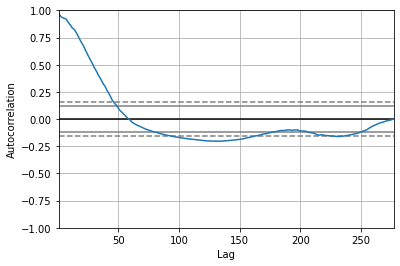

In [78]:
autocorrelation_plot(traindata)

<AxesSubplot:xlabel='Date'>

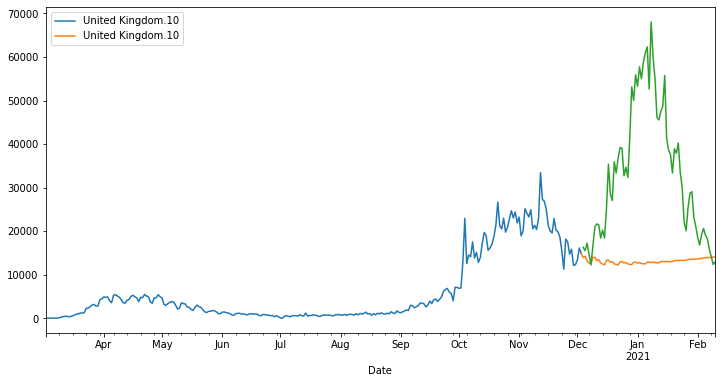

In [79]:
# creating date index as auto_arima only outputs list without index
preddates = pd.date_range(traindata.index[-1],periods=pred_horizon+1,freq=traindata.index.freq)[1:]
pred = pd.Series(model.predict(n_periods=pred_horizon), index=preddates)
pyhat= pd.Series(traindata.tail(1).squeeze(), index=[traindata.index[-1]]).append(pred)

fig, ax = plt.subplots()

traindata.plot(figsize=(12,6), ax=ax)
pyhat.plot(ax=ax)
testdata.plot(ax=ax)

In [49]:
newmodel = SARIMAX(traindata, order=(2,1,3))
fitresult = newmodel.fit()

pred = fitresult.predict(start=len(traindata), end=len(traindata)+pred_horizon)
pyhat= pd.Series(traindata.tail(1).squeeze(), index=[traindata.index[-1]]).append(pred)


<AxesSubplot:xlabel='Date'>

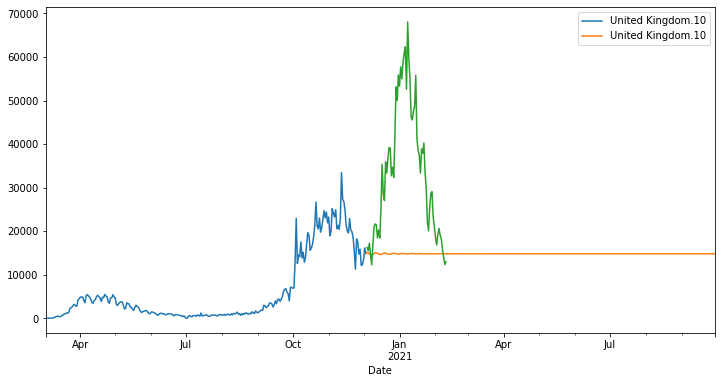

In [50]:
fig, ax = plt.subplots()

traindata.plot(figsize=(12,6), ax=ax)
pyhat.plot(ax=ax)
testdata.plot(ax=ax)

<AxesSubplot:xlabel='Date'>

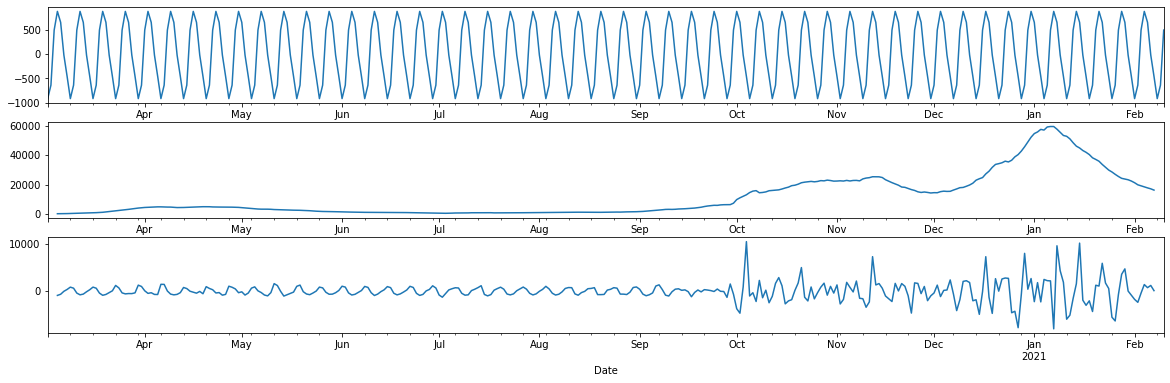

In [74]:
res = seasonal_decompose(tsdata, model='add')
fig, ax = plt.subplots(figsize=(20,6), nrows=3, ncols=1)
res.seasonal.plot(ax=ax[0])
res.trend.plot(ax=ax[1])
res.resid.plot(ax=ax[2])


In [ ]:
newmodel = SARIMAX(traindata, order=(3,1,2))
fitresult = newmodel.fit()

pred = fitresult.predict(start=len(traindata), end=len(traindata)+pred_horizon)
pyhat= pd.Series(traindata.tail(1).squeeze(), index=[traindata.index[-1]]).append(pred)

In [ ]:
fig, ax = plt.subplots()

traindata.plot(figsize=(12,6), ax=ax)
pyhat.plot(ax=ax)
testdata.plot(ax=ax)

In [ ]:
sm.tsa.adfuller(tempdata)

In [ ]:
hwmodel = ExponentialSmoothing(traindata,trend='add',seasonal='add').fit()

pred = hwmodel.forecast(len(testdata))



<AxesSubplot:xlabel='Date'>

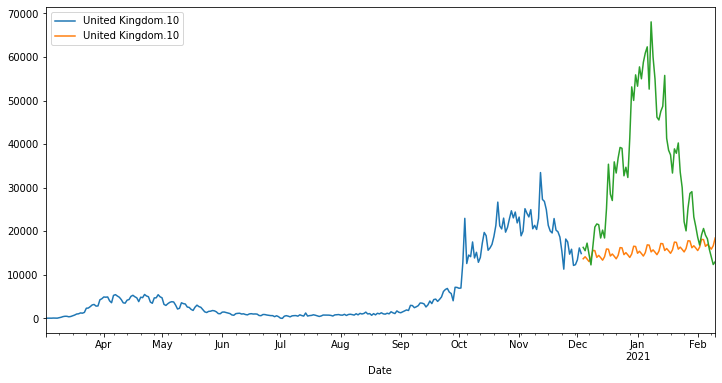

In [176]:
fig, ax = plt.subplots()
traindata.plot(figsize=(12,6),ax=ax)
pred.plot(ax=ax)
testdata.plot(ax=ax)

## App Development

In [81]:
# Load Data
df = px.data.tips()
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    return px.scatter(
        df, x="total_bill", y="tip", color="size",
        color_continuous_scale=colorscale,
        render_mode="webgl", title="Tips"
    )
# Run app and display result inline in the notebook
app.run_server(mode='inline')

In [162]:
pyhat.name

'United Kingdom.10'

In [192]:
def make_prediction(traindf, testdf):
    # make predictions
    pred_horizon = len(testdf)-1
    model = auto_arima(traindf)
    preddates = pd.date_range(traindf.index[-1],periods=pred_horizon+1,freq=traindf.index.freq)[1:]
    pred = pd.Series(model.predict(n_periods=pred_horizon), index=preddates)
    pyhat= pd.Series(traindf.tail(1).squeeze(), index=[traindf.index[-1]]).append(pred)
    pyhat.rename_axis('Date',inplace=True)
    pyhat.rename(traindf.columns[0], inplace=True)

    # merge for plotting
    tsdf = pd.merge(traindf,testdf,how='outer',on='Date')
    tsdf = pd.merge(tsdf, pyhat, how='outer', on='Date')
    tsdf.columns=['Training Data', 'Test Data', 'Forecast']
    
    return tsdf

In [275]:
# Load Data

plotdf = make_prediction(traindata, testdata)



# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("COVID-19 Timeseries Analysis"),
    dcc.Graph(id='graph'),
    html.Label([
        "Country",
        dcc.Dropdown(
            id='country-dropdown', clearable=False,
            value='US', options=[
                {'label': c[0] + c[1], 'value': c[0]}
                for c in zip(casesdf.columns[1:],
                             casesdf.iloc[0,1:].replace(np.nan,'').apply(lambda x:'' if x=='' else ' - '+x))
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("country-dropdown", "value")]
)
def update_figure(country):
    # skipping first row (header row) and resetting index to begin at 0
    dates = pd.to_datetime(casesdf['Country/Region'][1:], format="%m/%d/%y")
    tsdata = pd.DataFrame(casesdf[country][1:])
    tsdata.index = dates
    tsdata.index.freq='d' # setting time frequency to be by date
    tsdata = tsdata.rename_axis('Date')
    tsdata = tsdata[tsdata.index>'03-01-2020']

    # splitting 80% into trainset and 20% into testset
    sersplit = round(len(tsdata)*0.8)
    traindata = tsdata.iloc[:sersplit]
    testdata = tsdata.iloc[sersplit-1:]

    plotdf = make_prediction(traindata,testdata)
    
    fig = px.line(plotdf, title='Confirmed Cases Forecasting', labels={'y':'Confirmed Cases'})
    return fig
# Run app and display result inline in the notebook
app.run_server(mode='inline')